In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

image_size = (120, 120)
class_names_label

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [3]:
def load_data():
    
    datasets = ["../input/intel-image-classification/seg_train/seg_train", "../input/intel-image-classification/seg_test/seg_test"]
    output = []
    
    for dataset in datasets:
        images = []
        labels = []
        print("Loading {}".format(dataset))
        
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size) 
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

def load_pred_images():
    path = "../input/intel-image-classification/seg_pred/seg_pred"
    
    images = []
    
    
    for file in tqdm(os.listdir(path)):
                
                img_path = os.path.join(path, file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size) 
                
                images.append(image)
                
    images = np.array(images, dtype = 'float32')
    
    return images

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  1%|          | 25/2404 [00:00<00:09, 245.76it/s]

Loading ../input/intel-image-classification/seg_train/seg_train


  7%|▋         | 36/553 [00:00<00:01, 357.51it/s]

Loading ../input/intel-image-classification/seg_test/seg_test


100%|██████████| 437/437 [00:01<00:00, 347.48it/s]


# <span style="color:blue">1 - data preprocessing </span>

### <b>After loading the data for training and testing, we first apply a shuffle to the data so we can avoid fitting issues when we train the model. Second, we rescale each set of images from base values between 0 and 255 to values between 0 and 1 so it would be easier to train the model.</b>

In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=300)
test_images, test_labels = shuffle(test_images, test_labels, random_state=300)

In [6]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# <span style="color:blue">2 - data visualization </span>

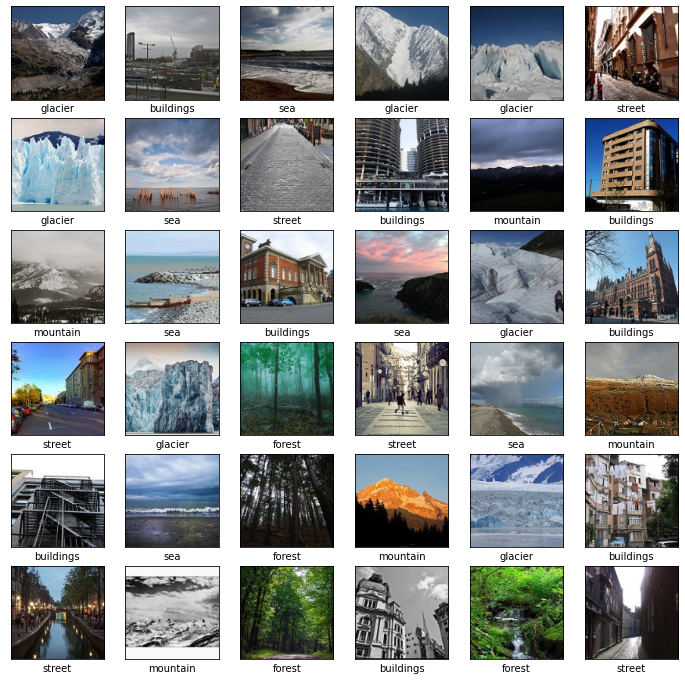

In [7]:
plt.figure(figsize=(12,12))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### <b><span style="color:red"> What we can notice from the visualization above, some images can lead to misinterpretations. Even humans can interpret these images differently, like some images that share confusing details, or for example images that can be interpreted as a mountain image even if they are glacier. These results foreshadow a risk of overfitting or underfitting depending on the class.</span></b>

# <span style="color:blue">3 - model creation and training</span>


In [8]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (120, 120, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

### <b>To prevent overfitting when we train the model we add many dropout layers which will create some noise by randomly sets inputs to 0.</b>

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        3

In [10]:
model.compile(optimizer='adam', loss ='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
historys = model.fit(train_images, train_labels, epochs=19, validation_data=(test_images, test_labels), shuffle=True)

Epoch 1/19
439/439 [==============================] - 6s 14ms/step - loss: 1.1434 - accuracy: 0.5539 - val_loss: 0.9981 - val_accuracy: 0.6343
Epoch 2/19
439/439 [==============================] - 5s 12ms/step - loss: 0.8104 - accuracy: 0.6919 - val_loss: 0.6637 - val_accuracy: 0.7587
Epoch 3/19
439/439 [==============================] - 5s 12ms/step - loss: 0.6272 - accuracy: 0.7641 - val_loss: 0.6036 - val_accuracy: 0.7807
Epoch 4/19
439/439 [==============================] - 5s 12ms/step - loss: 0.5212 - accuracy: 0.8109 - val_loss: 0.5848 - val_accuracy: 0.7950
Epoch 5/19
439/439 [==============================] - 5s 12ms/step - loss: 0.4310 - accuracy: 0.8454 - val_loss: 0.5936 - val_accuracy: 0.7847
Epoch 6/19
439/439 [==============================] - 5s 12ms/step - loss: 0.3730 - accuracy: 0.8642 - val_loss: 0.5824 - val_accuracy: 0.8060
Epoch 7/19
439/439 [==============================] - 5s 12ms/step - loss: 0.3219 - accuracy: 0.8788 - val_loss: 0.5676 - val_accuracy: 0.8143

In [12]:
model.save('CNN.model')

### <b>We save the model we just trained so we can use it later</b>

# <span style="color:blue">model analysis</span>


94/94 - 0s - loss: 0.8377 - accuracy: 0.8060

Test accuracy: 0.8059999942779541


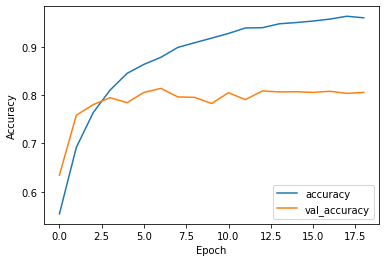

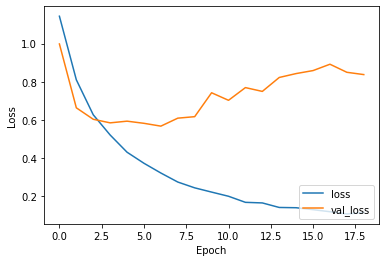

In [13]:
plt.figure()
plt.plot(historys.history['accuracy'], label='accuracy')
plt.plot(historys.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.figure()
plt.plot(historys.history['loss'], label='loss')
plt.plot(historys.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

# <span style="color:blue">Predection</span>

In [14]:
prediction_model=models.load_model("./CNN.model")

In [15]:
pred_image = load_pred_images()
pred_image = shuffle(pred_image, random_state=300)
pred_image = pred_image / 255.0

100%|██████████| 7301/7301 [00:20<00:00, 352.36it/s]


In [16]:
predictions = prediction_model.predict(pred_image)
shuffle(predictions)

array([[7.0311230e-01, 1.7966215e-11, 2.9191381e-07, 1.3789022e-12,
        7.2113461e-11, 2.9688743e-01],
       [7.8323072e-05, 1.1726341e-10, 1.5570012e-01, 2.1452031e-05,
        8.4419417e-01, 5.9291287e-06],
       [5.5514938e-06, 4.8761544e-06, 8.4286276e-03, 9.9156028e-01,
        6.9571155e-07, 2.9343038e-11],
       ...,
       [1.5825398e-03, 3.3070002e-04, 7.8912064e-02, 2.4968058e-02,
        8.9321202e-01, 9.9462667e-04],
       [5.9970347e-08, 9.9999988e-01, 2.1094301e-15, 5.7997619e-21,
        2.4481282e-13, 1.4353378e-08],
       [9.9500394e-05, 7.2506907e-07, 6.3861233e-07, 3.5611611e-11,
        1.0981814e-10, 9.9989915e-01]], dtype=float32)

In [17]:
def plot_image(i, predictions_array, img):
    img = img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],100*np.max(predictions_array)),color="#060083")

def plot_value_array(i, predictions_array):
    plt.grid(False)
    plt.xticks(range(6))
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('#00FF78')

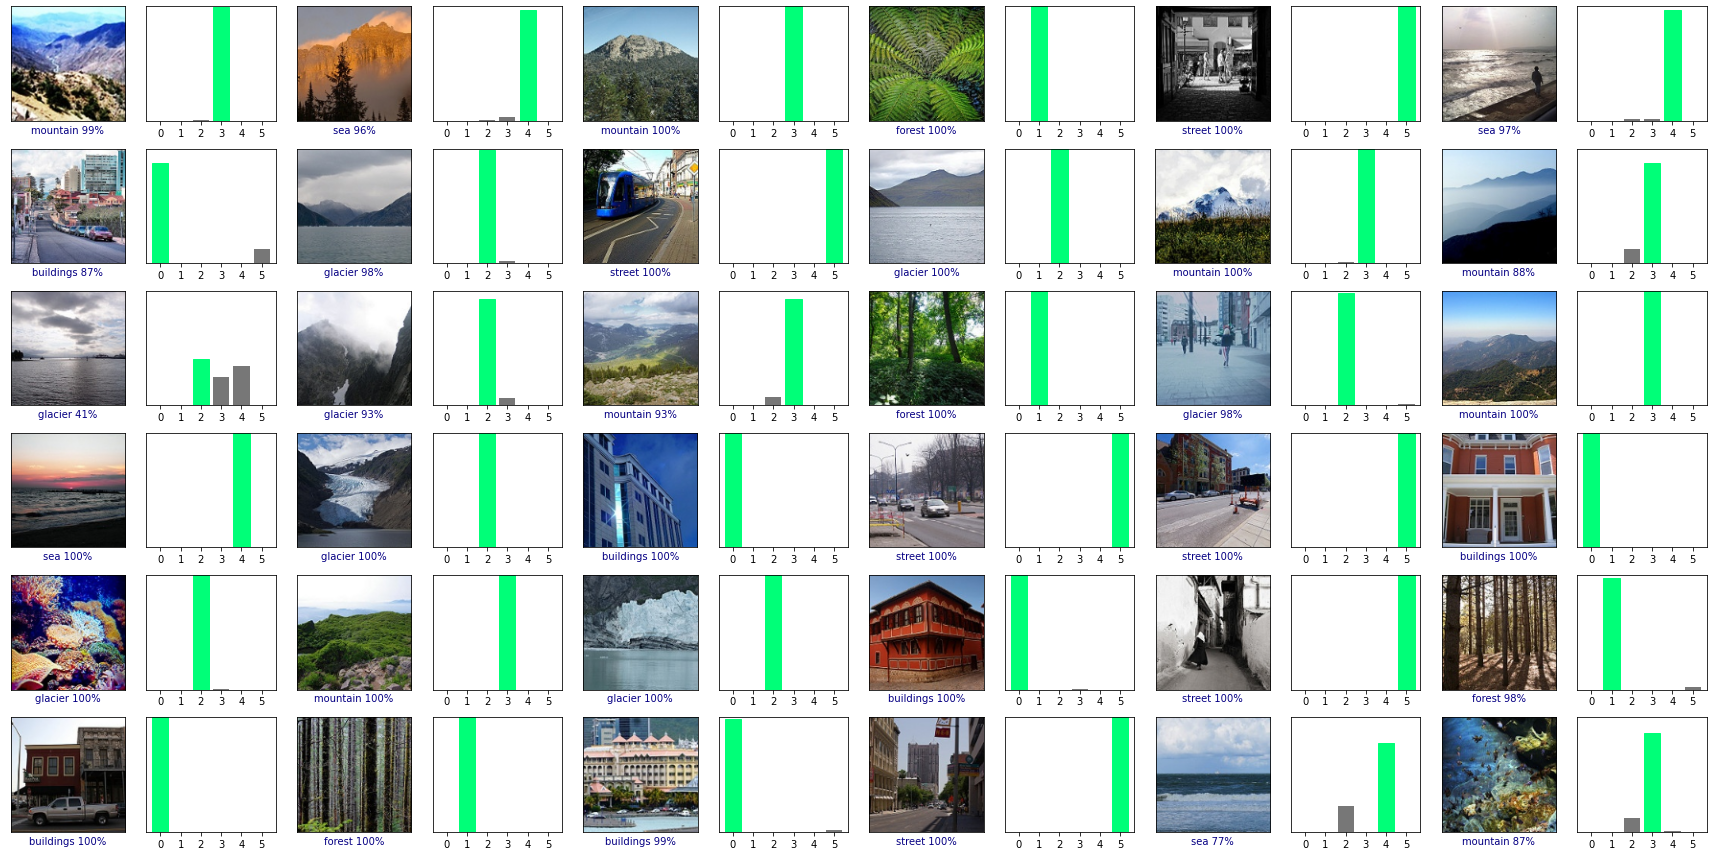

In [18]:
num_rows = 6
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], pred_image)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i])
plt.tight_layout()
plt.show()

# <span style="color:red">conclusion</span>



### <b>The conclusion that we can extract from the analysis of the model and the prediction made just above that the model works overall well with a precision of 80% but we obtain a validation-loss of 83%. We can explain this loss by 2 major reasons that lead to this. The first one is the balancing of the dataset, the number of images for each class is not equal in the training-set which can cause overfitting. In addition, we can notice that there are some who are assigned in a class which does not correspond to them. The second reason is the optimization of the model. The model is not fully optimized even if we add more layers the accuracy doesn't increase more then 1 or 2% but there is a solution that can give us a powerful model its deep learning. Some optimization algorithms for DL if applied to our model may lead to better accuracy and reduce loss also extracting features from the dataset then train the model with those features that can have an impact on the behavior of the model.</b>

PS. the result of the model behaivor may change if you run again the notebook from the start 